# Dataset Statistics/exploration

Try to understand the quality of the data better

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)   # go one level up
print(os.getcwd())            # check

from functools import partial
from xflow import SqlProvider
from xflow.data import pipe_each
from xflow.data.transform import TransformRegistry
import xflow.extensions.physics
from config_utils import load_config, detect_machine
from utils import *

# Detect machine once
experiment_name = "CAE_validate_clear"
machine = detect_machine()

# Use it in load_config
config = load_config(
    f"{experiment_name}.yaml",
    machine=machine
)

c:\Users\qiyuanxu\Documents\GitHub\fiber-image-reconstruction-comparison
[config_utils] Using machine profile: win-qiyuanxu


--------------------------------------------------------------------------------
Connected to SQLite database with 3 tables
--------------------------------------------------------------------------------


Processing:   0%|          | 0/2627 [00:00<?, ?it/s]

Processing: 100%|██████████| 2627/2627 [00:04<00:00, 603.30it/s]


Batch: 2627 images processed


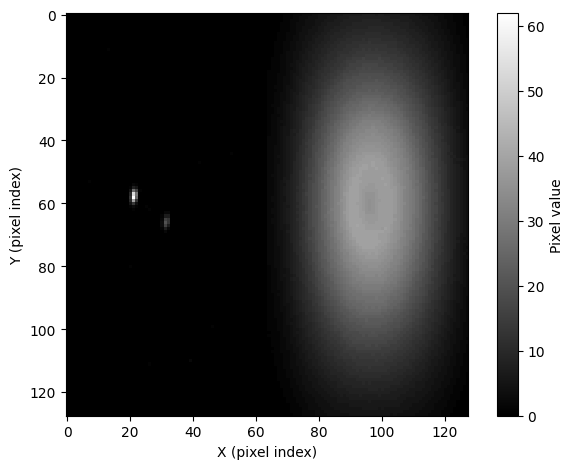

In [4]:
from xflow.utils import plot_image

test_dir = config["paths"]["chromox_01"]
# Create SqlProvider to query the database
db_path = f"{test_dir}/db/dataset_meta.db"
query = """
SELECT 
    image_path
FROM mmf_dataset_metadata 
WHERE batch IN (10, 11, 12)
--LIMIT 20
"""
realbeam_provider = SqlProvider(
    sources={"connection": db_path, "sql": query}, output_config={'list': "image_path"}
)

image_paths = realbeam_provider()

results = list(pipe_each(
    image_paths,
    partial(TransformRegistry.get("add_parent_dir"), parent_dir=test_dir),
    TransformRegistry.get("load_image"),
    TransformRegistry.get("to_narray"),
    partial(TransformRegistry.get("resize"), size=(128, 128)), 
    progress=True
))
print(f"Batch: {len(results)} images processed")

plot_image(results[0])

In [ ]:
# ==================== 
# Prepare Dataset (Wednesday Chromox)
# ====================

test_dir = config["paths"]["chromox_01"]
# Create SqlProvider to query the database
db_path = f"{test_dir}/db/dataset_meta.db"
query = """
SELECT 
    image_path
FROM mmf_dataset_metadata 
WHERE batch IN (10, 11, 12)
--LIMIT 20
"""
realbeam_provider = SqlProvider(
    sources={"connection": db_path, "sql": query}, output_config={'list': "image_path"}
)
train_provider, evaluation_provider = realbeam_provider.split(ratio=config["data"]["train_val_split"], seed=config["seed"])
val_provider, test_provider = evaluation_provider.split(ratio=config["data"]["val_test_split"], seed=config["seed"])

# For train dataset
config["data"]["transforms"]["torch"].insert(0, {
    "name": "add_parent_dir",
    "params": {
        "parent_dir": test_dir
    }
})
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])
train_dataset, n1 = make_dataset(train_provider, transforms)
val_dataset, n2 = make_dataset(val_provider, transforms)
test_dataset, n3 = make_dataset(test_provider, transforms)

In [ ]:
realbeam_provider()